_Lambda School Data Science_ 

This sprint, your project is about water pumps in Tanzania. Can you predict which water pumps are faulty?

# Confusion Matrix

#### Objectives
- get and interpret the confusion matrix for classification models
- use classification metrics: precision, recall
- understand the relationships between precision, recall, thresholds, and predicted probabilities
- understand how Precision@K can help make decisions and allocate budgets

#### Install category_encoders
- Local, Anaconda: `conda install -c conda-forge category_encoders`
- Google Colab: `pip install category_encoders`

#### Downgrade Matplotlib? Need version != 3.1.1

Because of this issue: [sns.heatmap top and bottom boxes are cut off](https://github.com/mwaskom/seaborn/issues/1773)

> This was a matplotlib regression introduced in 3.1.1 which has been fixed in 3.1.2 (still forthcoming). For now the fix is to downgrade matplotlib to a prior version.

This _isn't_ required for your homework, but is required to run this notebook. `pip install matplotlib==3.1.0`

In [ ]:
# !pip install category_encoders matplotlib==3.1.0

### Review: Load data, fit model

In [1]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()

    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']    
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Drop duplicate columns
    duplicate_columns = ['quantity_group']
    X = X.drop(columns=duplicate_columns)
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these like null values
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    
    # When columns have zeros and shouldn't, they are like null values
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        
    return X


LOCAL = '../data/tanzania/'
WEB = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Tree-Ensembles/master/data/tanzania/'
source = WEB

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(source + 'train_features.csv'), 
                 pd.read_csv(source + 'train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(source + 'test_features.csv')
sample_submission = pd.read_csv(source + 'sample_submission.csv')

# Split train into train & val. Make val the same size as test.
train, val = train_test_split(train, test_size=len(test),  
                              stratify=train['status_group'], random_state=42)

# Wrangle train, validate, and test sets in the same way
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

# Arrange data into X features matrix and y target vector
target = 'status_group'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

# Make pipeline!
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.8140409527789386


## Get and interpret the confusion matrix for classification models

[Scikit-Learn User Guide — Confusion Matrix](https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix)

In [2]:
from sklearn.metrics import confusion_matrix;
cm = confusion_matrix(y_val, y_pred);
cm

array([[7005,  171,  622],
       [ 555,  332,  156],
       [1098,   68, 4351]])

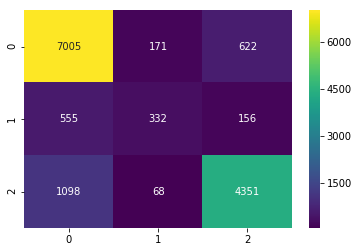

In [3]:
sns.heatmap(cm, cmap='viridis', annot=True, fmt='d')

In [4]:
columns = [f'Predicted "{c}"' for c in y_val.unique()];
columns

['Predicted "non functional"',
 'Predicted "functional"',
 'Predicted "functional needs repair"']

In [5]:
index_names = [f'Actual "{c}"' for c in y_val.unique()];
index_names

['Actual "non functional"',
 'Actual "functional"',
 'Actual "functional needs repair"']

In [6]:
df = pd.DataFrame(cm, columns=columns, index=index_names);

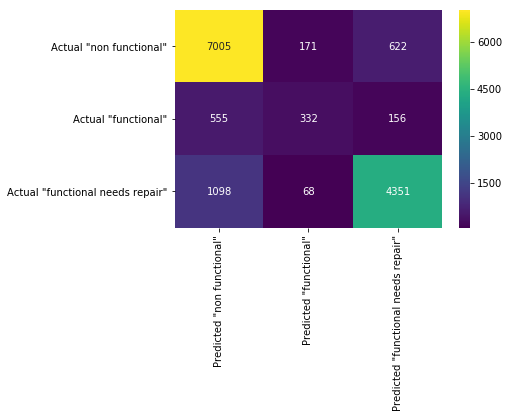

In [7]:
sns.heatmap(df, cmap='viridis', annot=True, fmt='d')

In [8]:
from sklearn.utils.multiclass import unique_labels;

In [9]:
unique_labels(y_val)

array(['functional', 'functional needs repair', 'non functional'],
      dtype='<U23')

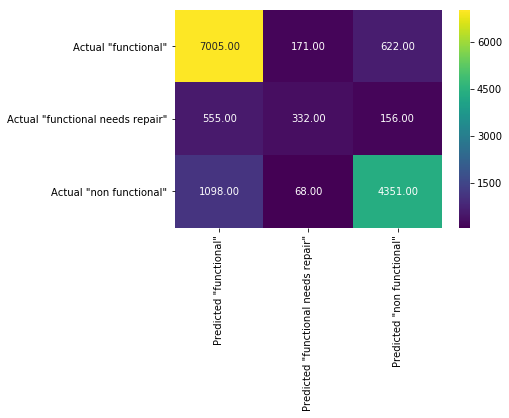

In [10]:
def plot_confusion_matrix(y_true, y_pred, normalize=False):
    cm = confusion_matrix(y_true, y_pred);
    labels = unique_labels(y_true);
    columns = [f'Predicted "{c}"' for c in labels];
    index_names = [f'Actual "{c}"' for c in labels];
    if(normalize):
        cm = cm/cm.sum(axis=1).reshape(y_true.nunique(), 1);
    df = pd.DataFrame(cm, columns=columns, index=index_names);
    sns.heatmap(df, cmap='viridis', annot=True, fmt='.2f')
plot_confusion_matrix(y_val, y_pred);

#### How many correct predictions were made?

In [11]:
7005+332+4351

11688

In [12]:
sum(y_val == y_pred)

11688

#### How many total predictions were made?

In [13]:
len(y_val)

14358

In [14]:
cm.sum()

14358

#### What was the classification accuracy?

In [15]:
11688/14358

0.8140409527789386

In [16]:
sum(y_val == y_pred)/len(y_val)

0.8140409527789386

## Use classification metrics: precision, recall
[Scikit-Learn User Guide — Classification Report](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report)

In [17]:
from sklearn.metrics import classification_report;
#help(classification_report)
print(classification_report(y_val, y_pred));

                         precision    recall  f1-score   support

             functional       0.81      0.90      0.85      7798
functional needs repair       0.58      0.32      0.41      1043
         non functional       0.85      0.79      0.82      5517

              micro avg       0.81      0.81      0.81     14358
              macro avg       0.75      0.67      0.69     14358
           weighted avg       0.81      0.81      0.81     14358



#### Wikipedia, [Precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall)

> Both precision and recall are based on an understanding and measure of relevance.

> Suppose a computer program for recognizing dogs in photographs identifies 8 dogs in a picture containing 12 dogs and some cats. Of the 8 identified as dogs, 5 actually are dogs (true positives), while the rest are cats (false positives). The program's precision is 5/8 while its recall is 5/12.

> High precision means that an algorithm returned substantially more relevant results than irrelevant ones, while high recall means that an algorithm returned most of the relevant results.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" width="400">

#### [We can get precision & recall from the confusion matrix](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context))

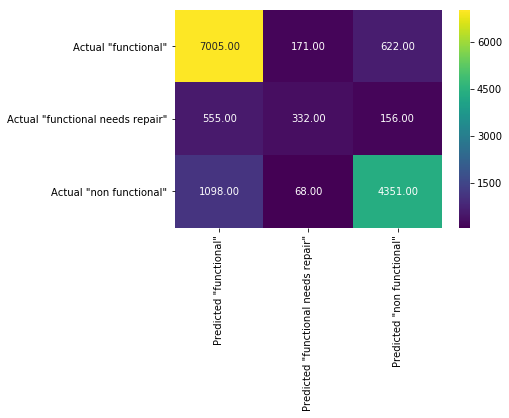

In [18]:
plot_confusion_matrix(y_val, y_pred)

#### How many correct predictions of "non functional"?

In [19]:
correct_predictions_nonfunctional = 4351;
correct_predictions_nonfunctional

4351

#### How many total predictions of "non functional"?

In [20]:
total_predictions_nonfunctional = 622 + 156 + 4351;
total_predictions_nonfunctional

5129

#### What's the precision for "non functional"?

In [21]:
correct_predictions_nonfunctional/total_predictions_nonfunctional

0.8483135114057321

#### How many actual "non functional" waterpumps?

In [22]:
actual_nonfunctional = 1098 + 68 + 4351;
actual_nonfunctional

5517

#### What's the recall for "non functional"?

In [23]:
correct_predictions_nonfunctional/actual_nonfunctional

0.7886532535798442

In [24]:
classification_report(y_val, y_pred, output_dict=True)['non functional']['precision']

0.8483135114057321

## Understand the relationships between precision, recall, thresholds, and predicted probabilities. Understand how Precision@K can help make decisions and allocate budgets

### Imagine this scenario...

Suppose there are over 14,000 waterpumps that you _do_ have some information about, but you _don't_ know whether they are currently functional, or functional but need repair, or non-functional.

In [25]:
len(test)

14358

**You have the time and resources to go to just 2,000 waterpumps for proactive maintenance.** You want to predict, which 2,000 are most likely non-functional or in need of repair, to help you triage and prioritize your waterpump inspections.

You have historical inspection data for over 59,000 other waterpumps, which you'll use to fit your predictive model.

In [26]:
len(train) + len(val)

59400

You have historical inspection data for over 59,000 other waterpumps, which you'll use to fit your predictive model.

Based on this historical data, if you randomly chose waterpumps to inspect, then about 46% of the waterpumps would need repairs, and 54% would not need repairs.

In [27]:
y_train.value_counts(normalize=True)

functional                 0.543071
non functional             0.384241
functional needs repair    0.072688
Name: status_group, dtype: float64

**Can you do better than random at prioritizing inspections?**

In this scenario, we should define our target differently. We want to identify which waterpumps are non-functional _or_ are functional but needs repair:

In [28]:
y_train = y_train != 'functional'
y_val = y_val != 'functional'
y_train.value_counts(normalize=True)

False    0.543071
True     0.456929
Name: status_group, dtype: float64

We already made our validation set the same size as our test set.

In [29]:
len(val) == len(test)

True

We can refit our model, using the redefined target.

Then make predictions for the validation set.

In [30]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

In [34]:
y_pred_proba = pipeline.predict_proba(X_val);
y_pred_proba

array([[0.  , 1.  ],
       [0.26, 0.74],
       [0.9 , 0.1 ],
       ...,
       [0.91, 0.09],
       [0.41, 0.59],
       [0.98, 0.02]])

And look at the confusion matrix:

In [37]:
y_pred_proba[:, 1]

array([1.  , 0.74, 0.1 , ..., 0.09, 0.59, 0.02])

In [33]:
confusion_matrix(y_val, y_pred)

array([[6821,  977],
       [1528, 5032]])

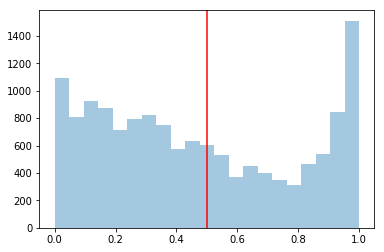

In [41]:
ax = sns.distplot(y_pred_proba[:, 1], kde=False);
ax.axvline(0.5, color='r')

In [42]:
y_pred = y_pred_proba[:, 1] > 0.6;
pd.Series(y_pred).value_counts()

False    9401
True     4957
dtype: int64

#### How many total predictions of "True" ("non functional" or "functional needs repair") ?

In [ ]:
y_

#### We don't have "budget" to take action on all these predictions

- But we can get predicted probabilities, to rank the predictions. 
- Then change the threshold, to change the number of positive predictions, based on our budget.

### Get predicted probabilities and plot the distribution

### Change the threshold

In [48]:
from ipywidgets import interact, fixed;

In [44]:
y_prob = y_pred_proba[:, 1];

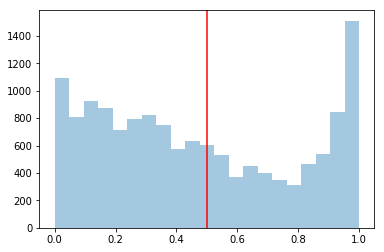

              precision    recall  f1-score   support

       False       0.82      0.87      0.84      7798
        True       0.84      0.77      0.80      6560

   micro avg       0.83      0.83      0.83     14358
   macro avg       0.83      0.82      0.82     14358
weighted avg       0.83      0.83      0.82     14358



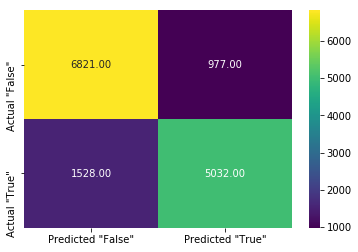

In [45]:
def set_threshold(y_true, y_prob, thresh):
    y_pred = y_prob > thresh;
    ax = sns.distplot(y_prob, kde=False);
    ax.axvline(thresh, color='r');
    plt.show();
    plot_confusion_matrix(y_true, y_pred);
    print(classification_report(y_true, y_pred));
    
set_threshold(y_val, y_prob, 0.5);

In [51]:
interact(set_threshold,
        y_true=fixed(y_val),
        y_prob=fixed(y_prob),
        thresh=(0, 1, 0.05))

interactive(children=(FloatSlider(value=0.0, description='thresh', max=1.0, step=0.05), Output()), _dom_classe…

<function __main__.set_threshold(y_true, y_prob, thresh)>

### In this scenario ... 

Accuracy _isn't_ the best metric!

Instead, change the threshold, to change the number of positive predictions, based on the budget. (You have the time and resources to go to just 2,000 waterpumps for proactive maintenance.)

Then, evaluate with the precision for "non functional"/"functional needs repair".

This is conceptually like **Precision@K**, where k=2,000.

Read more here: [Recall and Precision at k for Recommender Systems: Detailed Explanation with examples](https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54)

> Precision at k is the proportion of recommended items in the top-k set that are relevant

> Mathematically precision@k is defined as: `Precision@k = (# of recommended items @k that are relevant) / (# of recommended items @k)`

> In the context of recommendation systems we are most likely interested in recommending top-N items to the user. So it makes more sense to compute precision and recall metrics in the first N items instead of all the items. Thus the notion of precision and recall at k where k is a user definable integer that is set by the user to match the top-N recommendations objective.

We asked, can you do better than random at prioritizing inspections?

If we had randomly chosen waterpumps to inspect, we estimate that only 920 waterpumps would be repaired after 2,000 maintenance visits. (46%)

But using our predictive model, in the validation set, we succesfully identified over 1,600 waterpumps in need of repair!

So we will use this predictive model with the dataset of over 14,000 waterpumps that we _do_ have some information about, but we _don't_ know whether they are currently functional, or functional but need repair, or non-functional.

We will predict which 2,000 are most likely non-functional or in need of repair.

We estimate that approximately 1,600 waterpumps will be repaired after these 2,000 maintenance visits.

So we're confident that our predictive model will help triage and prioritize waterpump inspections.

# Assignment
- Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in this lecture notebook.

If your Kaggle Public Leaderboard score is:
- **Nonexistent**: You need to work on your model and submit predictions
- **< 70%**: You should work on your model and submit predictions
- **70% < score < 80%**: You may want to work on visualizations and write a blog post
- **> 80%**: You should work on visualizations and write a blog post


## Stretch goals — Highly Recommended Links
- Read Google Research's blog post, [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), and explore the interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- Read the blog post, [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415). You can replicate the code as-is,  ["the hard way"](https://docs.google.com/document/d/1ubOw9B3Hfip27hF2ZFnW3a3z9xAgrUDRReOEo-FHCVs/edit). Or you can apply it to the Tanzania Waterpumps data.
- Read this [notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb).
- (Re)read the [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) and watch the 35 minute video.